# ML - Homework 2
In this homework, we are invited to solve an image classification problem to learn the behaviour of a racing car in a Gym environment.

# Import libraries and definition functions

Import libraries that contains the implementations of the functions used in the rest of the program.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras import regularizers
from keras import optimizers
import pandas as pd
import os
import pickle

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as pltCM

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None,  cmap=pltCM.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

   # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [str(c) for c in classes]  # Converte le classi in stringhe
    classes = list(classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = pltCM.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    pltCM.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


from keras.callbacks import Callback

class Wait_Early_Stopping(Callback):
    def __init__(self, monitor='val_loss', patience=10, start_from_epoch=15):
        super(Wait_Early_Stopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.start_from_epoch = start_from_epoch
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None

        if 'acc' in self.monitor:
            self.monitor_op = np.greater
        else:
            self.monitor_op = np.less

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0.5
        self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None or epoch < self.start_from_epoch:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        return monitor_value

# Classification problem


## Loading data
Now, we are going to load the test set and the train set.

In [3]:
test_path = '/Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/test'
train_path = '/Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/train'

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

X_train, y_train = [], np.array([])
for folder_name in listdir_nohidden(train_path):
  class_num = int(folder_name)
  folder_path = os.path.join(train_path, folder_name)
  for image_name in listdir_nohidden(folder_path):
    image_path = os.path.join(folder_path, image_name)
    image = mpimg.imread(image_path)
    X_train.append(image)
    y_train = np.append(y_train, class_num)
X_train = np.stack(X_train, axis = 0)
print(f'Training set: {X_train.shape[0]} images of shape {X_train[0].shape}')

X_test, y_test = [], np.array([])
for folder_name in listdir_nohidden(test_path):
  class_num = int(folder_name)
  folder_path = os.path.join(test_path, folder_name)
  for image_name in listdir_nohidden(folder_path):
    image_path = os.path.join(folder_path, image_name)
    image = mpimg.imread(image_path)
    X_test.append(image)
    y_test = np.append(y_test, class_num)
X_test = np.stack(X_test, axis = 0)
print(f'Test set: {X_test.shape[0]} images of shape {X_train[0].shape}')

X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test))

input_shape = X_train[0].shape
num_classes = 5


from keras.preprocessing.image import ImageDataGenerator
classnames = ['do nothing', 'steer left', 'steer right', 'gas', 'brake']

def preprocessing(X):
    X[:, 85:96, 0:12, :] = [0, 0, 0]
    X = np.dot(X[..., :], [0.299, 0.587, 0.114])
    X = X.reshape((X.shape[0], 96, 96, 1))
    return X

X_train_prep = preprocessing(X_train)
X_test_prep = preprocessing(X_test)
X = np.concatenate((X_train_prep, X_test_prep), 0)

batch_size = 64
data_gen = ImageDataGenerator(rescale = 1/255)
train_gen = data_gen.flow(X_train_prep, y_train, batch_size)
test_gen = data_gen.flow(X_test_prep, y_test, batch_size)
input_shape = X_train_prep.shape[1:]
print("Input shape: %s" %str(input_shape))

class_names = {
    0: 'do nothing',
    1: 'steer left',
    2: 'steer right',
    3: 'gas',
    4: 'brake'
}

Training set: 6369 images of shape (96, 96, 3)
Test set: 2749 images of shape (96, 96, 3)
Input shape: (96, 96, 1)


show a random image

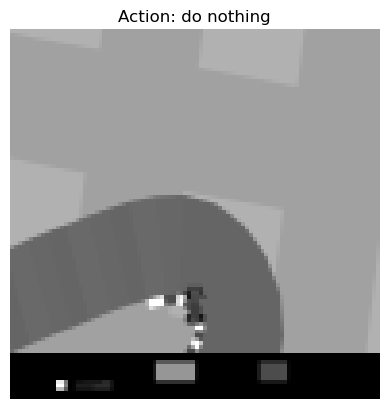

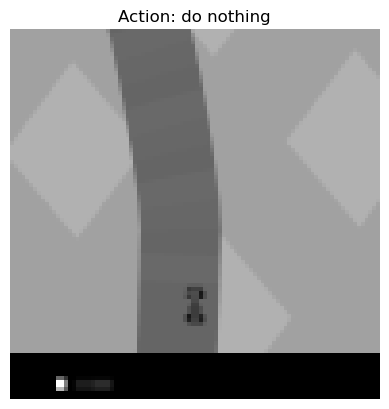

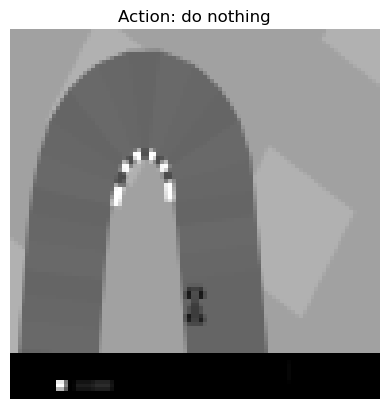

In [4]:
n = 3
X_photo, y_photo = train_gen.next()
for i in range(0,n):
    random_image = random.randrange(0,len(X_photo))
    image = X_photo[random_image]*255
    label = y_photo[random_image].argmax()
    plt.title(f'Action: {classnames[label]}')
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.show()

## Dataset info

## Train set

/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


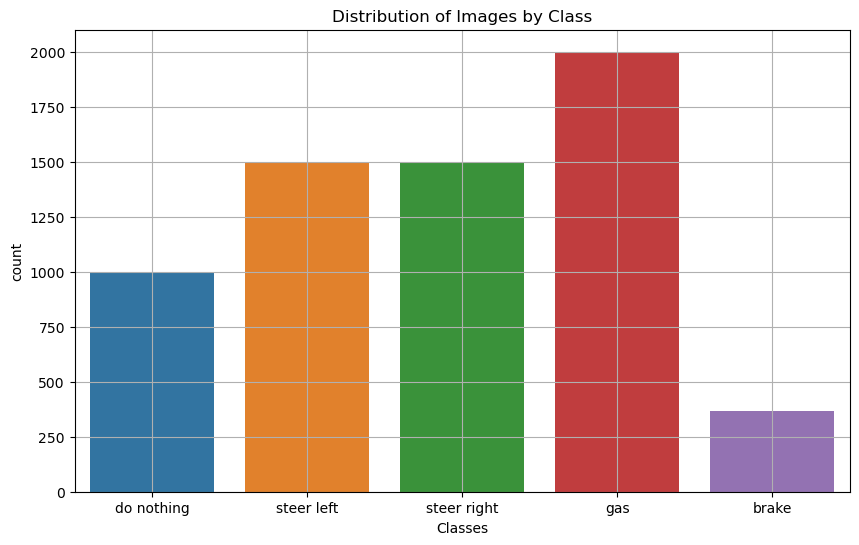

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
X, y = [], []

for folder_name in listdir_nohidden(train_path):
    class_num = int(folder_name)
    folder_path = os.path.join(train_path, folder_name)
    for image_name in listdir_nohidden(folder_path):
        y.append(class_num)

y = np.array(y)

classnames = [class_names[k] for k in sorted(class_names.keys())]

class_strings = [str(class_names[k]) for k in y]

data = {'Classes': class_strings}
df = pd.DataFrame(data)

df['Classes'] = pd.Categorical(df['Classes'], categories=classnames, ordered=True)
df = df.sort_values('Classes')

plt.figure(figsize=(10, 6))
sns.countplot(x='Classes', data=df)
plt.xlabel('Classes')
plt.title('Distribution of Images by Class')
plt.grid()
plt.show()

import plotly.express as px

class_names_list = [class_names[label] for label in y_train]
class_distribution = {class_name: class_names_list.count(class_name) for class_name in set(class_names_list)}
df = pd.DataFrame({'Classe': list(class_distribution.keys()), 'Numero di Immagini': list(class_distribution.values())})
fig = px.pie(df, names='Classe', values='Numero di Immagini', width=600, title='Distribuzione delle Classi')
fig.update_layout({"title": {'text': "Distribution of Classes on training set", "x": 0.5}})
fig.show()

## Test set

/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



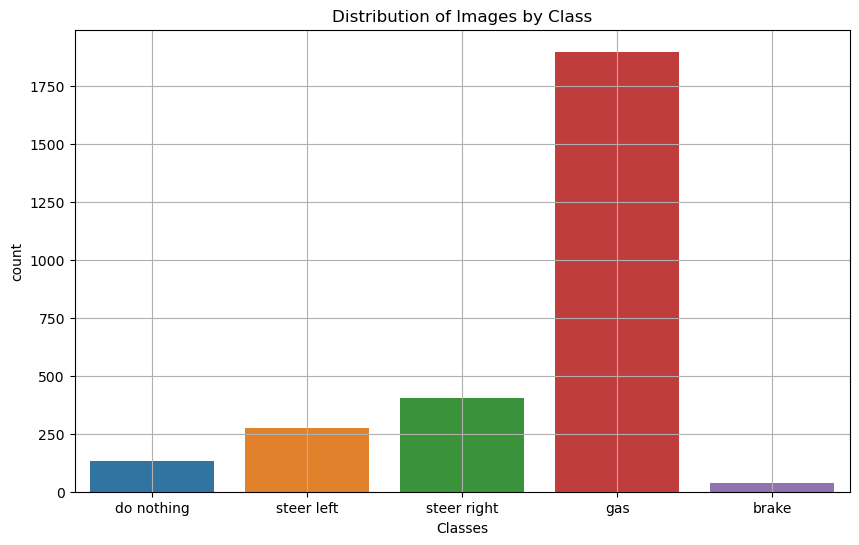

In [6]:
X, y = [], []

for folder_name in listdir_nohidden(test_path):
    class_num = int(folder_name)
    folder_path = os.path.join(test_path, folder_name)
    for image_name in listdir_nohidden(folder_path):
        y.append(class_num)

y = np.array(y)

classnames = [class_names[k] for k in sorted(class_names.keys())]

class_strings = [str(class_names[k]) for k in y]

data = {'Classes': class_strings}
df = pd.DataFrame(data)

df['Classes'] = pd.Categorical(df['Classes'], categories=classnames, ordered=True)
df = df.sort_values('Classes')

plt.figure(figsize=(10, 6))
sns.countplot(x='Classes', data=df)
plt.xlabel('Classes')
plt.title('Distribution of Images by Class')
plt.grid()
plt.show()

import plotly.express as px

class_names_list = [class_names[label] for label in y_test]
class_distribution = {class_name: class_names_list.count(class_name) for class_name in set(class_names_list)}
df = pd.DataFrame({'Classe': list(class_distribution.keys()), 'Numero di Immagini': list(class_distribution.values())})
fig = px.pie(df, names='Classe', values='Numero di Immagini', width=600, title='Distribuzione delle Classi')
fig.update_layout({"title": {'text': "Distribution of Classes on test set", "x": 0.5}})
fig.show()

{0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


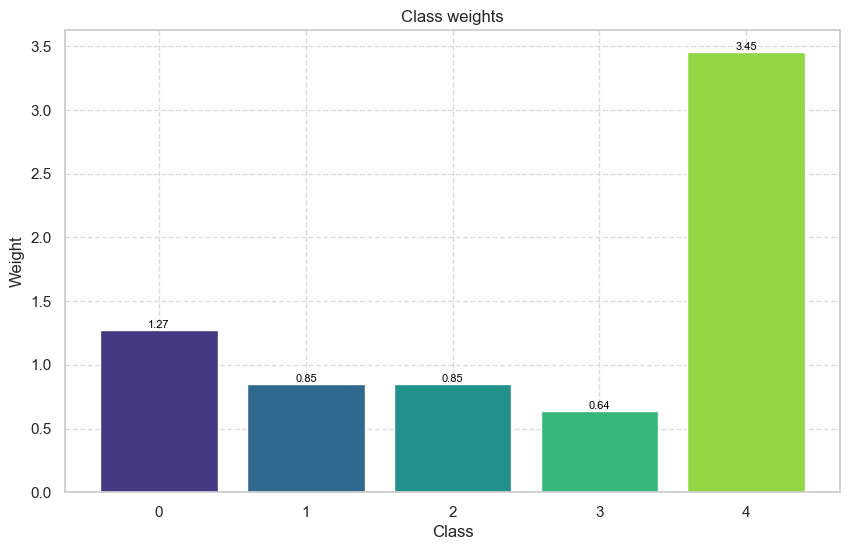

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = plt.bar(class_weight_dict.keys(), class_weight_dict.values(), color=sns.color_palette("viridis", len(class_weight_dict)))

plt.xlabel('Class')
plt.ylabel('Weight')
plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Class weights')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=8)

plt.show()

## Building models
To solve the problem of the classification of images we will define two different models that share the same structure. The two models will be two CNN. The two models will differ from the structure of the CNN (ie the various layers).

### ModelA


In [8]:
from keras.regularizers import l2

def ModelA(input_shape, num_classes, lr=0.001, weight_decay=1e-4):
    model = Sequential()    
    
    # Convolutional layers
    model.add(Conv2D(32, kernel_size=(5, 5), strides = (3, 3), input_shape=input_shape, padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(2, 2), kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Flatten the output for dense layers
    model.add(Flatten())

    # Dense layers
    model.add(Dense(256, kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Dropout(0.8))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

lr = 0.001
weight_decay = 1e-4
modelA = ModelA(input_shape, num_classes, lr, weight_decay)
modelA.summary()

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-01-12 19:10:29.011685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 19:10:29.014697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 activation_1 (Activation)   (None, 8, 8, 64)          0

### ModelB


In [9]:
from keras.regularizers import l2

def ModelB(input_shape, num_classes, lr=0.001, weight_decay=1e-4):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, kernel_size=(11, 11), strides=(5, 5), input_shape=input_shape, kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(5, 5), kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Flatten the output for dense layers
    model.add(Flatten())

    # Dense layers
    model.add(Dense(64, kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    sgd = optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

lr = 0.001
weight_decay = 1e-4
modelB = ModelB(input_shape,num_classes)
modelB.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        3904      
                                                                 
 activation_4 (Activation)   (None, 18, 18, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 9, 9, 32)         0         
 ooling2D)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 9, 9, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 64)          51264     
                                                                 
 activation_5 (Activation)   (None, 5, 5, 64)         

## Training models



In [10]:
early_stopping_val_loss = Wait_Early_Stopping(monitor='val_loss', patience=10, start_from_epoch=15)

#from keras.callbacks import EarlyStopping
#early_stopping_val_loss = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

### ModelA

In [11]:
epochs = 50
historyA = modelA.fit(X_train_prep, y_train, batch_size = 128, epochs=epochs, validation_data = (X_test_prep, y_test), callbacks=[early_stopping_val_loss], class_weight= class_weight_dict)

Epoch 1/50


2024-01-12 19:10:34.774034: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-12 19:10:35.097651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.7590 - accuracy: 0.3509

2024-01-12 19:10:37.549226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 3s 42ms/step - loss: 1.7590 - accuracy: 0.3509 - val_loss: 1.6516 - val_accuracy: 0.0142
Epoch 2/50
50/50 [==============================] - 2s 35ms/step - loss: 1.5228 - accuracy: 0.3734 - val_loss: 1.6278 - val_accuracy: 0.0142
Epoch 3/50
50/50 [==============================] - 1s 29ms/step - loss: 1.4722 - accuracy: 0.4359 - val_loss: 1.5381 - val_accuracy: 0.6639
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 1.4623 - accuracy: 0.4699 - val_loss: 1.4396 - val_accuracy: 0.6893
Epoch 5/50
50/50 [==============================] - 1s 27ms/step - loss: 1.4361 - accuracy: 0.4778 - val_loss: 1.5298 - val_accuracy: 0.2321
Epoch 6/50
50/50 [==============================] - 1s 29ms/step - loss: 1.4199 - accuracy: 0.5027 - val_loss: 1.6220 - val_accuracy: 0.0415
Epoch 7/50
50/50 [==============================] - 1s 29ms/step - loss: 1.4092 - accuracy: 0.4830 - val_loss: 1.4021 - val_accuracy: 0.6410
Epoch 8/50
50/50 [======

### ModelB

In [12]:
epochs = 50
historyB = modelB.fit(X_train_prep, y_train, batch_size = 128, epochs=epochs, validation_data = (X_test_prep, y_test), callbacks=[early_stopping_val_loss], class_weight= class_weight_dict)

Epoch 1/50


2024-01-12 19:11:25.512332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.8160 - accuracy: 0.3200

2024-01-12 19:11:28.092960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 3s 52ms/step - loss: 1.8160 - accuracy: 0.3200 - val_loss: 1.7224 - val_accuracy: 0.0484
Epoch 2/50
50/50 [==============================] - 2s 33ms/step - loss: 1.5370 - accuracy: 0.3961 - val_loss: 1.7881 - val_accuracy: 0.0484
Epoch 3/50
50/50 [==============================] - 2s 30ms/step - loss: 1.4544 - accuracy: 0.4379 - val_loss: 1.8163 - val_accuracy: 0.0527
Epoch 4/50
50/50 [==============================] - 1s 27ms/step - loss: 1.4184 - accuracy: 0.4533 - val_loss: 1.8473 - val_accuracy: 0.0993
Epoch 5/50
50/50 [==============================] - 2s 30ms/step - loss: 1.3872 - accuracy: 0.4669 - val_loss: 1.9326 - val_accuracy: 0.0953
Epoch 6/50
50/50 [==============================] - 2s 30ms/step - loss: 1.3686 - accuracy: 0.4812 - val_loss: 1.9098 - val_accuracy: 0.0957
Epoch 7/50
50/50 [==============================] - 2s 41ms/step - loss: 1.3512 - accuracy: 0.4911 - val_loss: 1.8881 - val_accuracy: 0.0979
Epoch 8/50
50/50 [======

## Save and load models and histories

In [103]:
def save_model(problem, model, history):
    models_dir = datadir + '/models/'
    model_name = f'{problem}_model.h5'
    history_name = f'{problem}_history.pkl'

    # Save model
    model_path = os.path.join(models_dir, model_name)
    model.save(model_path)
    print(f'\nModel saved successfully on file {model_path}\n')

    # Save history
    history_path = os.path.join(models_dir, history_name)
    with open(history_path, 'wb') as history_file:
        pickle.dump(history, history_file)
    print(f'History saved successfully on file {history_path}\n')


datadir = '/Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2'
problem_name_A = 'image_classification_problem_modelA'
problem_name_B = 'image_classification_problem_modelB'
problem_name_C = 'image_classification_problem_modelC'
save_model(problem_name_A, modelA, historyA)
save_model(problem_name_B, modelB, historyB)


Model saved successfully on file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelA_model.h5



INFO:tensorflow:Assets written to: ram://92f45a05-2b27-4b80-a51a-073af1a86b95/assets


INFO:tensorflow:Assets written to: ram://92f45a05-2b27-4b80-a51a-073af1a86b95/assets


History saved successfully on file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelA_history.pkl


Model saved successfully on file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelB_model.h5



INFO:tensorflow:Assets written to: ram://3674d213-606a-44c2-8f1e-88563b5edc3b/assets


INFO:tensorflow:Assets written to: ram://3674d213-606a-44c2-8f1e-88563b5edc3b/assets


History saved successfully on file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelB_history.pkl



In [67]:
from keras.models import load_model

def load_model_and_history(problem):
    models_dir = '/Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models'

    # Carica il modello
    model_path = os.path.join(models_dir, f'{problem}_model.h5')
    loaded_model = load_model(model_path)
    print(f'Model loaded successfully from file {model_path}')

    # Carica la cronologia
    history_path = os.path.join(models_dir, f'{problem}_history.pkl')
    with open(history_path, 'rb') as history_file:
        loaded_history = pickle.load(history_file)
    print(f'History loaded successfully from file {history_path}')

    return loaded_model, loaded_history

# Usa la funzione per caricare il modello e la cronologia
loaded_modelA, loaded_historyA = load_model_and_history('image_classification_problem_modelA')
loaded_modelB, loaded_historyB = load_model_and_history('image_classification_problem_modelB')

Model loaded successfully from file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelA_model.h5
History loaded successfully from file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelA_history.pkl
Model loaded successfully from file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelB_model.h5
History loaded successfully from file /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/models/image_classification_problem_modelB_history.pkl


## Evaluate the models
Accuracy on test set

In [13]:
from sklearn.metrics import classification_report, accuracy_score

def prediction_model(model,  X, y):
    y_pred = model.predict(X)

    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y, y_pred_classes)
    print(f'Accuracy: {accuracy:.4f}')

    report = classification_report(y, y_pred_classes, zero_division = np.nan)
    print('Classification Report:')
    print(report)

prediction_model(modelA, X_test_prep, y_test)
prediction_model(modelB, X_test_prep, y_test)

 1/86 [..............................] - ETA: 25s

2024-01-12 19:12:31.238394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 1s 4ms/step
Accuracy: 0.6151
Classification Report:
              precision    recall  f1-score   support

         0.0       0.29      0.38      0.33       133
         1.0       0.25      0.51      0.34       275
         2.0       0.48      0.59      0.53       406
         3.0       0.83      0.66      0.74      1896
         4.0       0.26      0.18      0.21        39

    accuracy                           0.62      2749
   macro avg       0.42      0.46      0.43      2749
weighted avg       0.69      0.62      0.64      2749

34/86 [==========>...................] - ETA: 0s

2024-01-12 19:12:31.893435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 0s 4ms/step
Accuracy: 0.5427
Classification Report:
              precision    recall  f1-score   support

         0.0       0.14      0.53      0.22       133
         1.0       0.40      0.29      0.34       275
         2.0       0.47      0.56      0.51       406
         3.0       0.83      0.58      0.69      1896
         4.0       0.05      0.26      0.08        39

    accuracy                           0.54      2749
   macro avg       0.38      0.44      0.37      2749
weighted avg       0.69      0.54      0.59      2749



In [14]:
def evaluate_model(model, X, y):
    loss, accuracy = model.evaluate(X, y, verbose=1)

    print(f'Test loss: {loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')

evaluate_model(modelA, X_test_prep, y_test)
evaluate_model(modelB, X_test_prep, y_test)

86/86 [==============================] - 1s 8ms/step - loss: 1.1927 - accuracy: 0.6151
Test loss: 1.1927
Test accuracy: 0.6151
86/86 [==============================] - 1s 8ms/step - loss: 1.3148 - accuracy: 0.5427
Test loss: 1.3148
Test accuracy: 0.5427


## Results
### Confusion matrix

86/86 [==============================] - 0s 3ms/step


<Figure size 640x480 with 0 Axes>

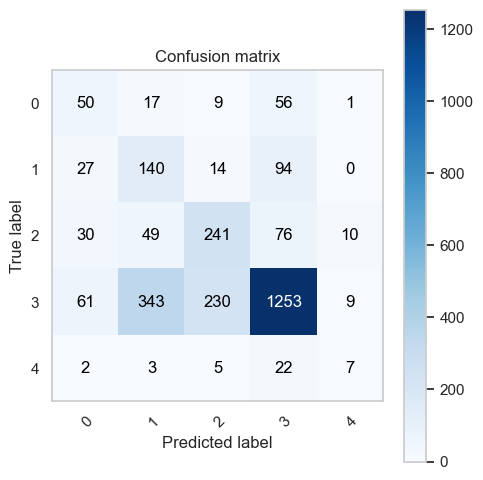

86/86 [==============================] - 0s 3ms/step


<Figure size 500x500 with 0 Axes>

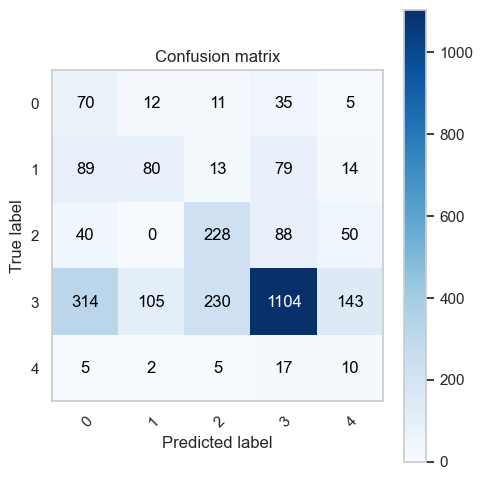

In [15]:
import matplotlib.pyplot as pltCM
pltCM.figure()
pltCM.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(y_test, np.argmax(modelA.predict(X_test_prep), axis=1), classes=class_names, normalize=False)
pltCM.grid(True, linestyle='--', alpha=0)
pltCM.show()

pltCM.figure()
pltCM.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(y_test, np.argmax(modelB.predict(X_test_prep), axis=1), classes=class_names, normalize=False)
pltCM.grid(True, linestyle='--', alpha=0)
pltCM.show()

### Accuracy and loss plots

/var/folders/71/43k_2j2111n2kj_plb9g7sgc0000gn/T/ipykernel_57717/3121718381.py:37: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/71/43k_2j2111n2kj_plb9g7sgc0000gn/T/ipykernel_57717/3121718381.py:40: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



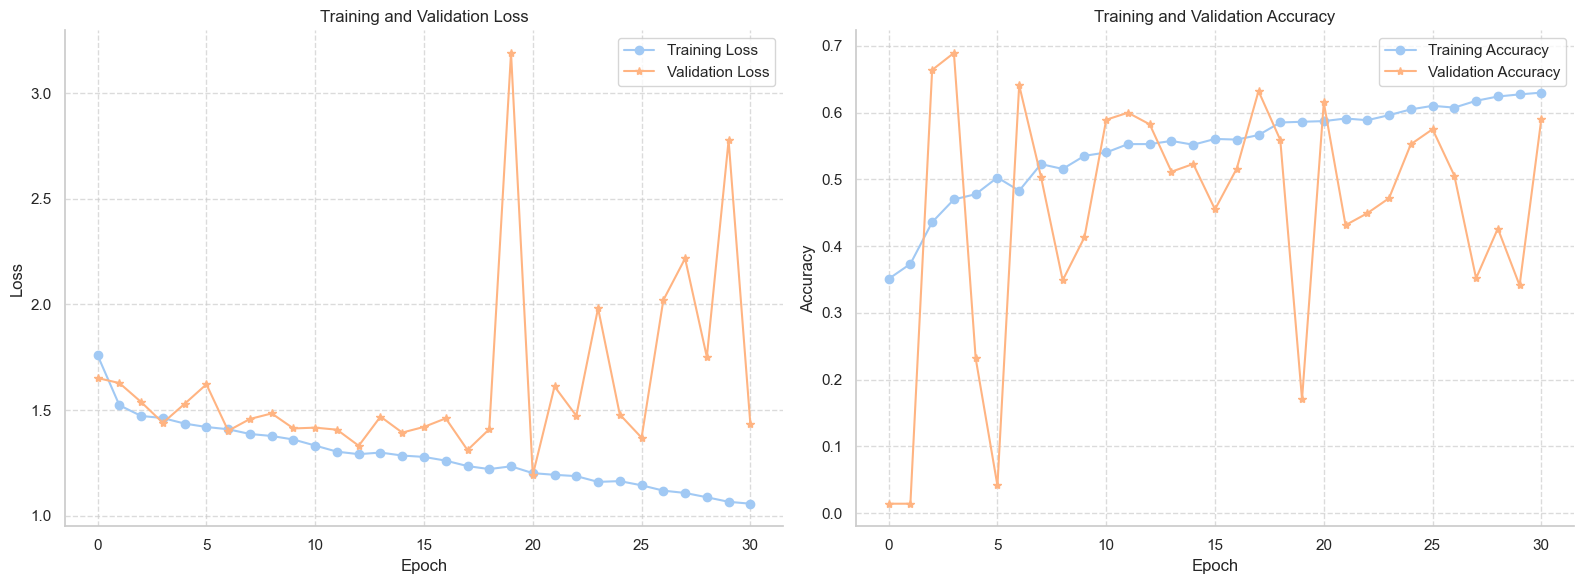

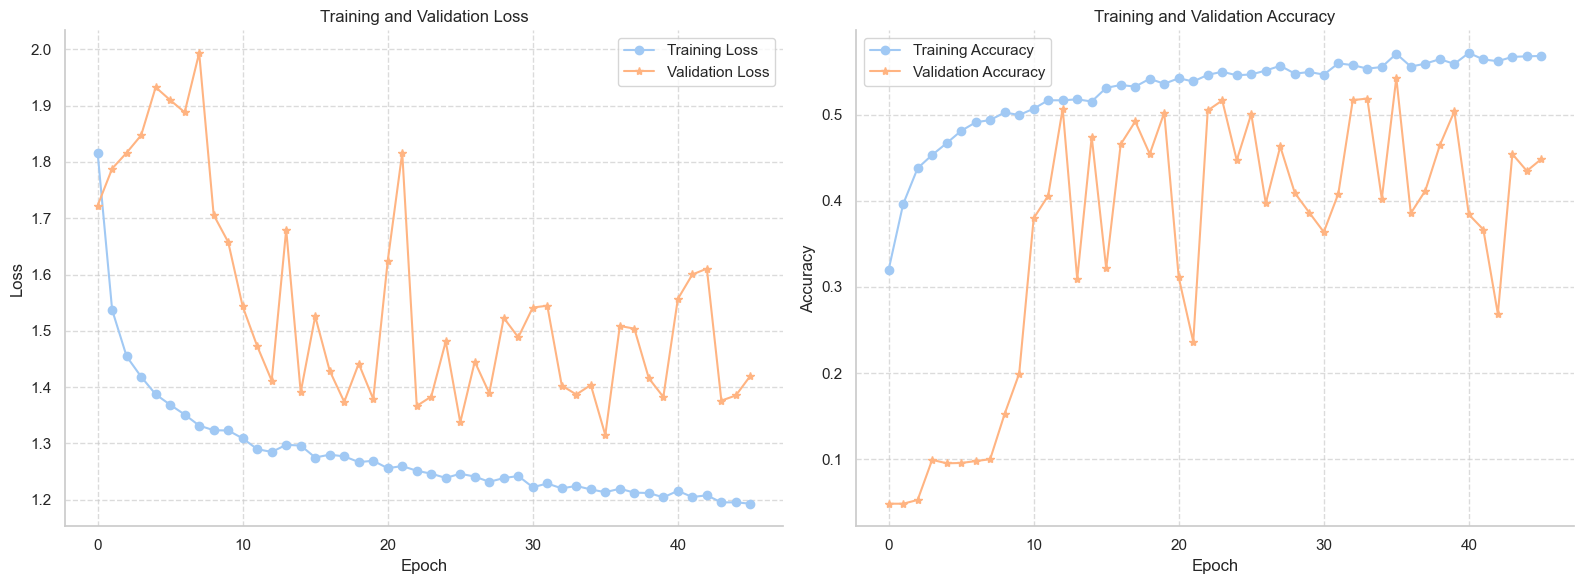

In [16]:
import matplotlib.pyplot as pltAcc
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True)

def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig, axes = pltAcc.subplots(figsize=(16, 6), ncols=2)

    axes[0].plot(loss, label='Training Loss', marker='o', linestyle='-')
    axes[0].plot(val_loss, label='Validation Loss', marker='*', linestyle='-')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)

    axes[1].plot(accuracy, label='Training Accuracy', marker='o', linestyle='-')
    axes[1].plot(val_accuracy, label='Validation Accuracy', marker='*', linestyle='-')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)

    sns.despine()
    pltAcc.tight_layout()

    return fig
    
# Creare e mostrare grafici di training
fig_historyA = plot_training_history(historyA)
fig_historyA.show()

fig_historyB = plot_training_history(historyB)
fig_historyB.show()

# Play the game

In [17]:
import sys
from gymnasium.wrappers import RecordVideo
import shutil


try:
    import gymnasium as gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model, seed=2000):

    obs, _  = env.reset(seed=seed)

    action0 = 0
    for i in range(50):
        obs,_,_,_,_ = env.step(action0)
    
    done = False
    while not done:
        obs = obs[np.newaxis,:, :, :]/255
        p = model.predict(preprocessing(obs), verbose = False) # adapt to your model
        action = np.argmax(p)  # adapt to your model
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'rgb_array'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

video_path = './videos'
if os.path.exists(video_path):
    shutil.rmtree(video_path)

envs = []
for i in range(5):
    seed = np.random.randint(1, 9999999)

    rec_env = RecordVideo(env, video_path+'/'+str(seed), name_prefix='model-A-'+str(seed))
    play(rec_env, modelA, seed)

    rec_env = RecordVideo(env, video_path+'/'+str(seed), name_prefix='model-B-'+str(seed))
    play(rec_env, modelB, seed)

Environment: CarRacing-v2
Action space: Discrete(5)
Observation space: Box(0, 255, (96, 96, 3), uint8)
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032/model-A-6248032-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032/model-A-6248032-episode-0.mp4



/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032/model-A-6248032-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032/model-B-6248032-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032/model-B-6248032-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6248032/model-B-6248032-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846/model-A-7765846-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846/model-A-7765846-episode-0.mp4



/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846/model-A-7765846-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846/model-B-7765846-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846/model-B-7765846-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/7765846/model-B-7765846-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124/model-A-6492124-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124/model-A-6492124-episode-0.mp4



/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124/model-A-6492124-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124/model-B-6492124-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124/model-B-6492124-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/6492124/model-B-6492124-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569/model-A-3488569-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569/model-A-3488569-episode-0.mp4



/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569/model-A-3488569-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569/model-B-3488569-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569/model-B-3488569-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/3488569/model-B-3488569-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281/model-A-9286281-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281/model-A-9286281-episode-0.mp4



/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281/model-A-9286281-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281/model-B-9286281-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281/model-B-9286281-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/9286281/model-B-9286281-episode-0.mp4


In [18]:
seed = 2000
rec_env = RecordVideo(env, video_path+'/'+str(seed), name_prefix='model-A-'+str(seed))
play(rec_env, modelA, seed)

rec_env = RecordVideo(env, video_path+'/'+str(seed), name_prefix='model-B-'+str(seed))
play(rec_env, modelB, seed)

Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000/model-A-2000-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000/model-A-2000-episode-0.mp4



/Users/simoneorelli/miniconda3/envs/learn-env-m1tf/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning:

WARN: Overwriting existing videos at /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000/model-A-2000-episode-0.mp4
Moviepy - Building video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000/model-B-2000-episode-0.mp4.
Moviepy - Writing video /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000/model-B-2000-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/simoneorelli/Library/Mobile Documents/com~apple~CloudDocs/Università /Subjects/II anno/I semester/Machine Learning/HW2/videos/2000/model-B-2000-episode-0.mp4


# Analysis of $val_{accuracy}$ and $val_{loss}$ in relation to kernel regularizer (l2 Ridge).

## Model A

In [1]:
def create_modelA(input_shape, num_classes, lr = 0.001, weight_decay = 0.0):
    model = ModelA(input_shape, num_classes, lr = lr, weight_decay = weight_decay)
    return model

epochs = 50
batch_size = 64
l2_values = [0, 1e-4, 1e-3, 1e-2, 1e-1]
num_models = len(l2_values)
modelsA = []
historiesA = []

for i in range(num_models):
    model = create_modelA(input_shape, num_classes, lr = 0.001, weight_decay = l2_values[i])
    historiesA.append(model.fit(X_train_prep, y_train, batch_size = 128, epochs=epochs, validation_data = (X_test_prep, y_test), callbacks=[early_stopping_val_loss], class_weight= class_weight_dict))
    modelsA.append(model)

NameError: name 'input_shape' is not defined

## Results

 1/86 [..............................] - ETA: 19s

2024-01-09 15:28:24.269218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/86 [..............................] - ETA: 16s

2024-01-09 15:28:26.002674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/86 [..............................] - ETA: 18s

2024-01-09 15:28:27.745938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/86 [..............................] - ETA: 16s

2024-01-09 15:28:29.433072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/86 [=>............................] - ETA: 0s 

2024-01-09 15:28:31.105078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 1s 5ms/step


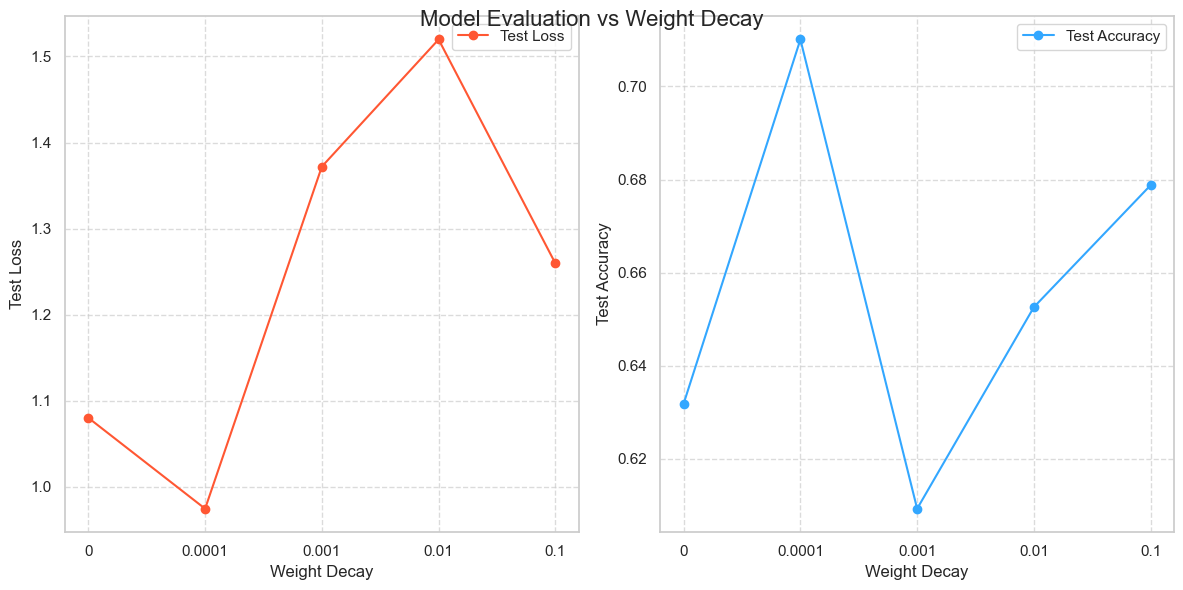

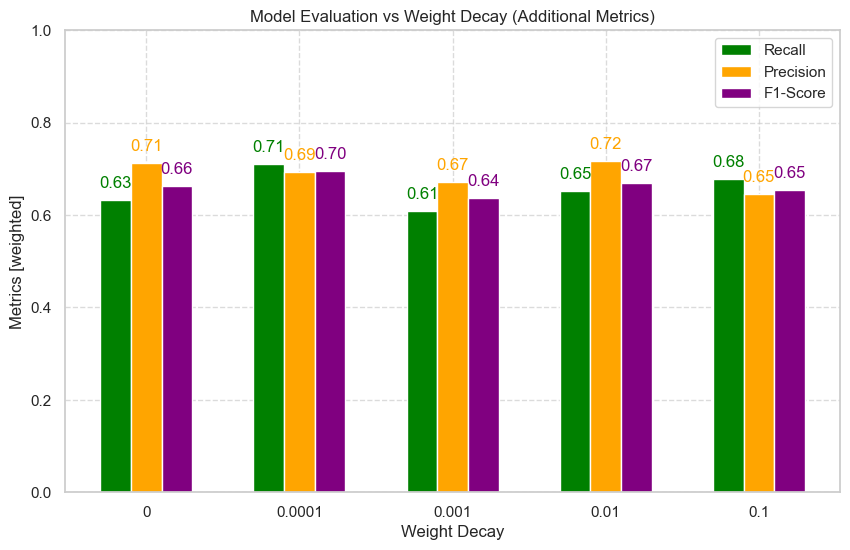

In [102]:
from sklearn.metrics import precision_recall_fscore_support

test_losses = []
test_accuracies = []
recall_values = []
precision_values = []
f1_score_values = []

def evaluate_model(model, X, y):
    loss, accuracy = model.evaluate(X, y, verbose=1)
    return loss, accuracy
def prediction_model(model,  X, y):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    precision, recall, f1_score, support = precision_recall_fscore_support(y, y_pred_classes, zero_division=np.nan, average='weighted')
    
    return precision, recall, f1_score

for i in range(num_models):
    model = modelsA[i]
    test_loss, test_accuracy = evaluate_model(model, X_test_prep, y_test)
    precision, recall, f1_score = prediction_model(model, X_test_prep, y_test)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_score_values.append(f1_score)

plt.figure(figsize=(12, 6))
desired_x_ticks = [0, 0.0001, 0.001, 0.01, 0.1] 
colors = ['#FF5733', '#33A7FF']

plt.subplot(1, 2, 1)
plt.plot(test_losses, marker='o', linestyle='-', color=colors[0], label='Test Loss')
plt.xlabel('Weight Decay')
plt.xticks(range(len(test_losses)), desired_x_ticks)
plt.ylabel('Test Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', linestyle='-', color=colors[1], label='Test Accuracy')
plt.xlabel('Weight Decay')
plt.xticks(range(len(test_accuracies)), desired_x_ticks)
plt.ylabel('Test Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.suptitle('Model Evaluation vs Weight Decay', fontsize=16)
plt.show()

width = 0.2
x_positions = np.arange(len(l2_values))

plt.figure(figsize=(10, 6))

plt.bar(x_positions - width, recall_values, width=width, color='green', label='Recall')
plt.bar(x_positions, precision_values, width=width, color='orange', label='Precision')
plt.bar(x_positions + width, f1_score_values, width=width, color='purple', label='F1-Score')

plt.title('Model Evaluation vs Weight Decay (Additional Metrics)')
plt.xlabel('Weight Decay')
plt.xticks(x_positions, l2_values)
plt.ylabel('Metrics [weighted]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)

plt.legend(loc='upper right')

for i, value in enumerate(recall_values):
    plt.text(i - width, value + 0.02, f'{value:.2f}', ha='center', va='bottom', color='green')
for i, value in enumerate(precision_values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom', color='orange')
for i, value in enumerate(f1_score_values):
    plt.text(i + width, value + 0.02, f'{value:.2f}', ha='center', va='bottom', color='purple')

plt.show()